<center> 
    <h1> Wrangling and Analizing 'WeRateDogs' Twitter Account </h1>
</center>

The following report summarizes steps taken to wrangle 'WeRateDogs' Twitter data to create interesting and trustworthy analyses and visualizations. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10 and a numerator `>10`. 

In [2]:
# importing necessary libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import statsmodels.api as sm

%matplotlib inline
sns.set(style="white", font_scale=1.2)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Gathering Data

Data comes from 3 sources:

- `twitter_archive_enhanced.csv` a file obtained from the twitter archive of the `WeRateDogs` account. The file can be obtained [here][1]
- `image_predictions.tsv` a file containing image predictions. The file was downloaded using `download_predictions.py` file.
- `tweet_json.json` a file obtained using the twitter API. Check the file: `twitter_api.py`

**Note:** It was my choice to remove the code for gathering the information from this notebook to reduce clutter and time. The code needed to download the data will be available as 2 seperate files and will be uploaded with the notebook.

[1]: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv

In [3]:
# lets first take a look at the first file
df = pd.read_csv('twitter_archive_enhanced.csv')
df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [4]:
# the second file contains a prediction of the images used
# it was downloaded using 'download_predictions.py'
image_df = pd.read_csv('image_predictions.tsv',sep='\t')
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
# finally the file we got from the twitter api
# find how we did it in 'twitter_api.py'
# we need to use read_json instead of read_csv for this to work
api_df = pd.read_json('tweets_extended.json',orient='index')
api_df.head(2)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
1991-02-08 13:48:08.022790149,NaN,NaN,2015-11-15 22:32:08+00:00,"[0, 131]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/BL...,2439,False,Here we have a Japanese Irish Setter. Lost eye...,NaN,...,NaN,NaN,NaN,NaN,468,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 16:08:05.002620928,NaN,NaN,2015-11-15 23:05:30+00:00,"[0, 139]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/r7...,121,False,This is a western brown Mitsubishi terrier. Up...,NaN,...,NaN,NaN,NaN,NaN,42,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'contributors_enabled': False, 'created_at': ..."


In [6]:
# finally a list of failed tweets, these tweets were probably deleted
with open('deleted_tweets.json','r') as file:
    deleted_tweets = json.load(file)
deleted_tweets[:4]

[888202515573088257,
 873697596434513921,
 872668790621863937,
 872261713294495745]

## Assessing Data
After collecting all the information we need, its time to assess the problems that we have. For that, it is important to keep in mind the key points required for the project:

    - We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, 
    not all are dog ratings and some are retweets.
    - Assess at least 8 quality issues and at least 2 tidiness issues in this dataset.
    - Cleaning includes merging individual pieces of data according to the rules of tidy data.
    
#### Main Table

In [7]:
df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


At a first glance, we can see that there are a lot of columns with 'NaN' values. These columns also appear to not be useful for our current project. Let's take a better look at the columns:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Since the keypoints above state that we only want original tweets and no replies or retweets, we have the following assessment points:

- columns \[`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_urls`, `source`\] are not needed in this project.

- The rows where some of these columns (e.g retweeted_status_timestamp) are not null are not relevant to this project since they indicate that the tweet is not original.

Now let's take a look at other columns:

In [9]:
# the id column:
df.query('tweet_id in @deleted_tweets').head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
101,872668790621863937,NaN,NaN,2017-06-08 04:17:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @loganamnosis: Penelope here is doing me qu...,8.726576e+17,1.547674e+08,2017-06-08 03:32:35 +0000,https://twitter.com/loganamnosis/status/872657...,14,10,None,None,None,None,None
104,872261713294495745,NaN,NaN,2017-06-07 01:19:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Harry. His ears are activated one at a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872261713...,13,10,Harry,None,None,None,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None


As we can see, some of these tweets are available here but have been deleted. These tweets are no longer required for our project since we can't use them with other tables.

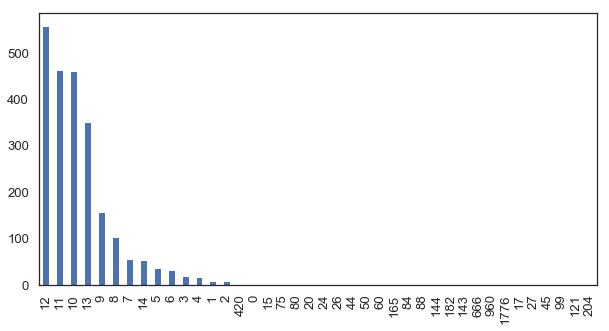

In [10]:
# in the project, it was indicated that the numerators might not be correct, lets see

df.rating_numerator.value_counts().plot(kind='bar',figsize=[10,5]);

We can see that most of these values are in the range [6-20]. other very large or very small values might be due to an error. Let's investigate this further.

In [11]:
pd.set_option('max_colwidth', -1)
df.query('rating_numerator < 2 ')['text']

315     When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag                           
605     RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…
1016    PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX                     
1446    After reading the comments I may have overestimated this pup. Downgraded to a 1/10. Please forgive me                                       
1869    What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table https://t.co/RDXCfk8hK0                   
1940    The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you                                                    
2038    After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look 

In [12]:
df.query('rating_numerator > 20 ')['text']

188     @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research                                                                                   
189     @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10                                    
290     @markhoppus 182/10                                                                                                                                                       
313     @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho                                                                       
340     RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…                             
433     The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd   

After some visual inspection, we can determine the main problems we have here:

- A very low rating is the result of:
    - People submitting an invalid picture (not of a dog). We can take care of this in the images table since we do not want any image that is not related to a dog.
- A very high rating is due to:
    - The tweet is not original (it is a reply to someone), we will not take care of this as well since we will remove any tweet that is not original.
    - There was a mistake in getting the number (usually because the number is decimal). We can check this only after we take care of other problems.
    - The author did really intend to give a high numerator rating (usually with a high denominator). No action is needed here.
    
So, in summary, we have a quality issue for both the rating numerator and the denominator:

- Some numerators and denomenators have not been taken properly from the text. 
- The type of the data should be float instead of integer to account for floats in the numerator

In [13]:
pd.reset_option('max_colwidth')

In [14]:
# check the timestamp column
df.timestamp.head()

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object

The timestamp variable is actually a combination of 2 variables: 'date' and 'time'.

In [15]:
# lets check the last columns
df.iloc[:,-5:]

,name,doggo,floofer,pupper,puppo
0,Phineas,None,None,None,None
1,Tilly,None,None,None,None
2,Archie,None,None,None,None
3,Darla,None,None,None,None
4,Franklin,None,None,None,None
...,...,...,...,...,...
2351,None,None,None,None,None
2352,a,None,None,None,None
2353,a,None,None,None,None
2354,a,None,None,None,None


One main problem we see here is the usage of 'None' instead of 'NaN' values. This would make it harder to check for null values.

In [16]:
df.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
          ... 
Kramer       1
Livvie       1
Fillup       1
Olaf         1
Nimbus       1
Name: name, Length: 957, dtype: int64

Again, we notice here the None value. In addition, 'a' as a name which suggests that the name was not scraped properly.

In [17]:
df.query('name == "a"').head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,8,10,a,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None


After further investigation, it appears that the account did not provide a name at all for some dogs. For that, 'a' names should also be null values.

In [18]:
df.iloc[:,-4:].describe()

,doggo,floofer,pupper,puppo
count,2356,2356,2356,2356
unique,2,2,2,2
top,None,None,None,None
freq,2259,2346,2099,2326


These final 4 columns seem to be very related. We can combine them into 1 `type` column and remove `None` values.

#### Images table

Now is the time to take a look at the images table which is a prediction of the type of the dog we have in the first table.

In [19]:
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


At a first glance, column names are confusing. A description of the columns was available on the original site:

- p1 is the algorithm's #1 prediction for the image in the tweet → golden retriever
- p1_conf is how confident the algorithm is in its #1 prediction → 95%
- p1_dog is whether or not the #1 prediction is a breed of dog → TRUE
- p2 is the algorithm's second most likely prediction → Labrador retriever
- etc

In [20]:
image_df.p1_conf.describe()

count    2075.000000
mean        0.594548
std         0.271174
min         0.044333
25%         0.364412
50%         0.588230
75%         0.843855
max         1.000000
Name: p1_conf, dtype: float64

In order to simplify matters, it would be easier for us to trust the algorithm's first prediction. This means that all columns starting with p2* and p3* won't be needed.

In [21]:
image_df.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

The above cell shows that there are about 500 images that are not for a dog. Since we want to simplify things, we will use only data that we think are for a dog. (all false fields are thus not required).

In [22]:
image_df.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
soccer_ball             1
silky_terrier           1
wooden_spoon            1
earthstar               1
boathouse               1
Name: p1, Length: 378, dtype: int64

We can see a similar problem here with names like 'electric_fan' and 'basketball'. As mentioned above, we should stick with data for dogs only.

Finally, one other tidiness issue is that the two tables should not be seperate since they are related to the same subject.
#### API Table

The table obtained from the api provides more extended information about the tweets.

In [23]:
api_df.head(2)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
1991-02-08 13:48:08.022790149,NaN,NaN,2015-11-15 22:32:08+00:00,"[0, 131]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/BL...,2439,False,Here we have a Japanese Irish Setter. Lost eye...,NaN,...,NaN,NaN,NaN,NaN,468,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 16:08:05.002620928,NaN,NaN,2015-11-15 23:05:30+00:00,"[0, 139]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/r7...,121,False,This is a western brown Mitsubishi terrier. Up...,NaN,...,NaN,NaN,NaN,NaN,42,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'contributors_enabled': False, 'created_at': ..."


In [24]:
api_df.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status_permalink', 'retweet_count', 'retweeted',
       'retweeted_status', 'source', 'truncated', 'user'],
      dtype='object')

- There are about 32 columns here. The only needed ones are: id, favorite_count, retweet_count.
- The table might not be useful on its own so we need to merge it with the other 2.

#### Assessment Summary
Finally, here is a list of the key points we found in our assessment.

##### Quality Issues
 -  **Main Table**
 
     - Some rows contain non-original tweets (replies, retweets)
     - columns \[in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, source\] are not needed in this project.
     - some tweets are deleted in the api_table but not in the main one
     - the type for rating numerator should be float.
     - Both rating numerator and denominator have wrong values.
     - Some of the values in the 'name' column are missing. and some have value 'a' when they should be missing.

- **Images Table**
    - column names [p1,p1_conf,p1_dog] are confusing
    - some images are not related to dogs
    - we only need the algorithms first guess.
    

- **API Table**

    - we only need 3 columns: [d, favorite_count, retweet_count]
   

##### Tidiness Issues
 -  **Main Table**
    - The timestamp variable is actually a combination of 2 variables: 'date' and 'time'.
    - The last 4 columns are a representation of 1 information: 'type'.

- **Images Table**
    - Since the images are related to the tweets. This table should also be part of the first table.

- **API Table**
    - Since favorite count and retweet count are related to the first table. This table should also be part of the first table.


### Cleaning

This is the final step in data wrangling. We should take the above points and clean them. 

The first step is usually to make a copy of all the tables we have:

In [25]:
df_clean = df.copy()
image_clean = image_df.copy()
api_clean = api_df.copy()

#### Define

In the main table, remove all non-original tweets (replies, retweets).

#### Code

In [26]:
# remove all non-original tweets

df_clean = df_clean[df_clean.in_reply_to_status_id.isnull() & df_clean.retweeted_status_id.isnull() ]

#### Test

In [27]:
assert df.shape[0] - df_clean.shape[0] == 181 + 78 # taken from the number of non-null values of both columns

#### Define

drop columns [in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls]
#### Code

In [28]:
df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id',
               'retweeted_status_id', 'retweeted_status_user_id', 
               'retweeted_status_timestamp', 'expanded_urls','source'], axis=1,inplace=True)

#### Test

In [29]:
df_clean.head(0)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define

Delete all rows with tweet_id in `deleted_tweets` list.

#### Code

In [30]:
df_clean = df_clean.query('tweet_id not in @deleted_tweets')

#### Test

In [31]:
assert df.shape[0] - df_clean.shape[0]- 181 - 78 > 0 # some of the deleted tweets were retweets, only 7 other tweets were deleted

#### Define

Get the numerator and denominator again as float values from the text.
#### Code

In [32]:
# We are going to use the regex to find the numerator and denominator again
# this time, we will assume that they are floats
test_str = df_clean.text[2]
reg_ex = r'(\d+(?:\.\d+)*)\/(\d+(?:\.\d+)*)'
df_clean['numerator'] = df_clean['text'].apply(lambda x: re.findall(reg_ex,x)[0][0]).astype('float')
df_clean['denominator'] = df_clean['text'].apply(lambda x: re.findall(reg_ex,x)[0][1]).astype('float')

# the check column is temporary to check for any mistakes
df_clean['check'] = df_clean['text'].apply(lambda x: len(re.findall(reg_ex,x)))

df_clean.head(2)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,numerator,denominator,check
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None,13.0,10.0,1
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None,13.0,10.0,1


#### Test

In [33]:
# we need to check the incorrect cases
# only 4 cases are present so we can check them individually
pd.set_option('max_colwidth',-1)
df_clean.query('rating_numerator != numerator')[['text','rating_numerator','numerator']]

,text,rating_numerator,numerator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,13.50
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,9.75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,11.27
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,11.26


In [34]:
df_clean.query('check >1')[['tweet_id','text','rating_numerator','numerator']]

,tweet_id,text,rating_numerator,numerator
766,777684233540206592,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",12,12.0
1007,747600769478692864,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,10,10.0
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,9.0
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,4.0
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50.0
1222,714258258790387713,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE,10,10.0
1359,703356393781329922,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf,9,9.0
1459,695064344191721472,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",4,4.0
1465,694352839993344000,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ,10,10.0
1508,691483041324204033,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,5,5.0


Since there aren't many cases where there are more than one number, we can investigate them manually. It seems that most of the time there are 2 ratings, it is because there are actually 2 dogs in the image (or more). It seems appropriate to leave this as the first match. However, there are few cases where this is not the case and should be fixed manually.

In [35]:
ids_to_fix =[ 722974582966214656, 716439118184652801, 695064344191721472, 682962037429899265, 666287406224695296]
# we reassign the values manually to each of the above tweets.
for id in ids_to_fix:
    df_new = df_clean.query('tweet_id == @id')
    df_clean.loc[df_clean.tweet_id == id,'numerator'] = float(re.findall(reg_ex,str(df_new['text']))[1][0])
    df_clean.loc[df_clean.tweet_id == id, 'denominator'] = float(re.findall(reg_ex,str(df_new['text']))[1][1])
df_clean.query('tweet_id in @ids_to_fix')[['text','rating_numerator','numerator','denominator']]

,text,rating_numerator,numerator,denominator
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,13.0,10.0
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,11.0,10.0
1459,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",4,13.0,10.0
1662,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,7,10.0,10.0
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,9.0,10.0


In [36]:
# finally we get rid of the temporary columns

df_clean.drop(['rating_numerator','rating_denominator','check'],axis=1,inplace=True)

In [37]:
df_clean.head(3)

,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo,numerator,denominator
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas,None,None,None,None,13.0,10.0
1,892177421306343426,2017-08-01 00:17:27 +0000,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,None,None,None,None,13.0,10.0
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie,None,None,None,None,12.0,10.0


#### Define

Replace 'None' and 'a' values with NaN values.

#### Code

In [38]:
df_clean['name'].replace('None',np.nan,inplace=True)
df_clean['name'].replace('a',np.nan,inplace=True)

#### Test

In [39]:
df_clean.name.value_counts()

Charlie    10
Cooper     10
Lucy       10
Oliver     10
Penny      9 
          .. 
Amy        1 
William    1 
Akumi      1 
Stubert    1 
Nimbus     1 
Name: name, Length: 951, dtype: int64

#### Define

Split the Timestamp variable into 'date' and 'time'

#### Code

In [40]:
df_clean['date'] = pd.to_datetime(df_clean['timestamp']).dt.date
df_clean['time'] = pd.to_datetime(df_clean['timestamp']).dt.time

In [41]:
df_clean.drop(['timestamp'],axis=1,inplace=True)

#### Test

In [42]:
df_clean.head()

,tweet_id,text,name,doggo,floofer,pupper,puppo,numerator,denominator,date,time
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas,None,None,None,None,13.0,10.0,2017-08-01,16:23:56
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,None,None,None,None,13.0,10.0,2017-08-01,00:17:27
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie,None,None,None,None,12.0,10.0,2017-07-31,00:18:03
3,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,Darla,None,None,None,None,13.0,10.0,2017-07-30,15:58:51
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",Franklin,None,None,None,None,12.0,10.0,2017-07-29,16:00:24


#### Define 

Combine the four columns: doggo, floofer, pupper, puppo into `type` column.

In [43]:
# Code
value_cols = ['doggo', 'floofer','pupper','puppo']
conditions =[df_clean[x] == x for x in value_cols]
df_clean['type'] = np.select(conditions, value_cols, default=np.nan)

In [44]:
df_clean.drop(value_cols, axis=1,inplace=True)

#### Test

In [45]:
df_clean['type'].value_counts()

nan        1755
pupper     221 
doggo      82  
puppo      23  
floofer    9   
Name: type, dtype: int64

In [46]:
df_clean.head(3)

,tweet_id,text,name,numerator,denominator,date,time,type
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas,13.0,10.0,2017-08-01,16:23:56,nan
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,13.0,10.0,2017-08-01,00:17:27,nan
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie,12.0,10.0,2017-07-31,00:18:03,nan


**Note** This  did not account for when 2 variables are present (e.g 'doggo' and 'pupper'). For simplicity reasons we will assume that in such cases there is an error and we use a default value of nan to account for it.

In [47]:
# it is a good idea to reset the index after all the deletions
df_clean = df_clean.reset_index(drop=True)
df_clean.tail(2)

,tweet_id,text,name,numerator,denominator,date,time,type
2088,666029285002620928,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,7.0,10.0,2015-11-15,23:05:30,nan
2089,666020888022790149,Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,8.0,10.0,2015-11-15,22:32:08,nan


Now is the time to look at the second table. Let's remember our key assessment points:

- images Table
    - Some column names (e.g p1,p1_conf,p1_dog) are confusing
    - some images are not related to dogs
    - we only need the algorithms first guess.

#### Define 
Remove all non-dog images from the dataset.

**Note**: At first, I was about to delete all columns after p1. However, further assessment showed that sometimes p1_dog will indicate that there is no dog while p2 will indicate, correctly, that there is one. For that, before deleting the columns it would be wise to create a seperate column to aggregate all the predictions.

In [48]:
# Here for example, we see that the first image should be of a dog.
image_clean.query('p2_dog == True & p1_dog == False').head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
22,666337882303524864,https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg,1,ox,0.416669,False,Newfoundland,0.278407,True,groenendael,0.102643,True
33,666430724426358785,https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg,1,llama,0.505184,False,Irish_terrier,0.104109,True,dingo,0.062071,False
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,0.167175,True,Chihuahua,0.086951,True
52,666996132027977728,https://pbs.twimg.com/media/CUGlb6iUwAITEbW.jpg,1,hay,0.507637,False,Rottweiler,0.062490,True,water_buffalo,0.048425,False
95,667550904950915073,https://pbs.twimg.com/media/CUOb_gUUkAACXdS.jpg,1,web_site,0.999335,False,vizsla,0.000081,True,collie,0.000069,True


In [49]:
# idea from here: https://stackoverflow.com/a/39111919/4145941
conditions = [
    (image_clean.p1_dog == True),
    (image_clean.p2_dog == True),
    (image_clean.p3_dog == True)
]
choices = [image_clean.p1, image_clean.p2, image_clean.p3]
confidences = [image_clean.p1_conf, image_clean.p2_conf, image_clean.p3_conf]
image_clean['is_dog'] = np.select(conditions, [True, True, True], default=False)
image_clean['prediction'] = np.select(conditions, choices, default=np.nan)
image_clean['confidence'] = np.select(conditions, confidences, np.nan )

#### Define
In order to remove all non-dogs from the dataset. It would be better to merge the first 2 tables first. In this way, we make sure to remove unnecessary tweets as well.

#### Code

In [50]:
# check the shape of two tables.
# some tweets may not have images
(df_clean.shape[0], image_clean.shape[0])

(2090, 2075)

In [51]:
# perform inner merge to remove all fields with no images
df_main = df_clean.merge(image_clean,how='inner',left_on='tweet_id',right_on='tweet_id')

#### Test

In [52]:
# it seems a lot of the rows got deleted
# this is fine since we want to simplify as much as we can
df_main.shape[0]

1964

In [53]:
# the table should include columns from both tables
df_main.head()

,tweet_id,text,name,numerator,denominator,date,time,type,jpg_url,img_num,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_dog,prediction,confidence
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas,13.0,10.0,2017-08-01,16:23:56,nan,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,...,False,bagel,0.085851,False,banana,0.076110,False,False,NaN,NaN
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,13.0,10.0,2017-08-01,00:17:27,nan,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,True,Pekinese,0.090647,True,papillon,0.068957,True,True,Chihuahua,0.323581
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie,12.0,10.0,2017-07-31,00:18:03,nan,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,True,malamute,0.078253,True,kelpie,0.031379,True,True,Chihuahua,0.716012
3,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,Darla,13.0,10.0,2017-07-30,15:58:51,nan,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,True,Labrador_retriever,0.168086
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",Franklin,12.0,10.0,2017-07-29,16:00:24,nan,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,True,basset,0.555712


#### Code
Now to actually remove all non-dogs from the dataset.


In [54]:
df_main = df_main[df_main.is_dog]

#### Test

In [55]:
df_main.query('p1_dog == False & p2_dog== False & p3_dog == False')

,tweet_id,text,name,numerator,denominator,date,time,type,jpg_url,img_num,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_dog,prediction,confidence


In [56]:
df_main.shape[0]

1659

#### Define
 Drop all unnecessary columns: [img_num, p1, p1_conf, p1_dog, p2, p2_dog, p2_conf, p3, p3_conf, p3_dog, is_dog]
#### Code

In [57]:
# remove all unnecessary columns
# is_dog is no longer required since all the values are True
cols_to_drop = ['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_dog', 'p2_conf', 'p3', 'p3_conf', 'p3_dog', 'is_dog']

df_main.drop(cols_to_drop, axis=1, inplace=True)

#### Test

In [58]:
#test
df_main.head(1)

,tweet_id,text,name,numerator,denominator,date,time,type,jpg_url,prediction,confidence
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,13.0,10.0,2017-08-01,00:17:27,nan,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581


#### Define

rename confusing columns. (at this stage, we only have one that could be renamed: jpg_url)

#### Code

In [59]:
df_main.rename({'jpg_url' : 'image_url'},axis=1,inplace=True) 

#### Test

In [60]:
df_main.head(1)

,tweet_id,text,name,numerator,denominator,date,time,type,image_url,prediction,confidence
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,13.0,10.0,2017-08-01,00:17:27,nan,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581


#### API Table
we only need 3 columns: [id, favorite_count, retweet_count]
#### Define
Drop all columns except (id, favorite_count and retweet_count)
#### Code

In [61]:
# idea from https://stackoverflow.com/questions/45846189
remaining_cols = ['id','favorite_count','retweet_count']
cols_to_drop = api_clean.columns.difference(remaining_cols)

api_clean.drop(cols_to_drop,axis=1,inplace=True)

#### Test

In [62]:
api_clean.head()

,favorite_count,id,retweet_count
1991-02-08 13:48:08.022790149,2439,666020888022790149,468
1991-02-08 16:08:05.002620928,121,666029285002620928,42
1991-02-08 17:16:52.701032449,114,666033412701032449,41
1991-02-08 20:17:06.329800704,274,666044226329800704,133
1991-02-08 21:40:48.165822465,99,666049248165822465,41


#### Define 

Merge `api_clean` with the previous tables.

#### Code 

In [63]:
# again an inner merge so we don't get retweets or deleted tweets
df_main = df_main.merge(api_clean, how='inner',left_on='tweet_id',right_on='id')

#### Test

In [64]:
df_main.head(3)

,tweet_id,text,name,numerator,denominator,date,time,type,image_url,prediction,confidence,favorite_count,id,retweet_count
0,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,13.0,10.0,2017-08-01,00:17:27,nan,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,31485,892177421306343426,5765
1,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie,12.0,10.0,2017-07-31,00:18:03,nan,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,23730,891815181378084864,3815
2,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,Darla,13.0,10.0,2017-07-30,15:58:51,nan,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,39868,891689557279858688,7951


In [65]:
# By testing we see that we still have the 'id' column which is not needed anymore
df_main.drop(['id'],axis=1,inplace=True)

In [66]:
df_main.head(2)

,tweet_id,text,name,numerator,denominator,date,time,type,image_url,prediction,confidence,favorite_count,retweet_count
0,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,13.0,10.0,2017-08-01,00:17:27,nan,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,31485,5765
1,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie,12.0,10.0,2017-07-31,00:18:03,nan,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,23730,3815


### Analysis

Finally, it is time for analysisng and visualizing the data.

In [67]:
# show numerical data
df_main.describe()

,tweet_id,numerator,denominator,confidence,favorite_count,retweet_count
count,1.659000e+03,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000
mean,7.392510e+17,11.320542,10.444846,0.550645,8720.330922,2542.206148
std,6.793112e+16,7.250618,6.274852,0.298918,12805.517900,4618.234260
min,6.660209e+17,0.000000,7.000000,0.000010,72.000000,11.000000
25%,6.774323e+17,10.000000,10.000000,0.305147,1981.000000,569.000000
50%,7.139006e+17,11.000000,10.000000,0.550506,4078.000000,1264.000000
75%,7.931581e+17,12.000000,10.000000,0.822520,10748.500000,2875.000000
max,8.921774e+17,165.000000,150.000000,0.999956,157937.000000,78664.000000


In [68]:
# show categorical data
df_main.describe(include='object')

,text,name,date,time,type,image_url,prediction
count,1659,1213,1659,1659,1659,1659,1659
unique,1659,847,577,1623,5,1659,113
top,This is Bruce. He's a rare pup. Covered in Frosted Flakes. Nifty gold teeth. Overall good dog. 7/10 would pet firmly https://t.co/RtxxACzZ8A,Cooper,2015-11-29,00:08:17,nan,https://pbs.twimg.com/media/CVWy9v-VAAALSoE.jpg,golden_retriever
freq,1,10,22,3,1403,1,156


In [69]:
# for some reason it still uses nan as a string
df_main['type'].replace('nan',np.nan,inplace=True)

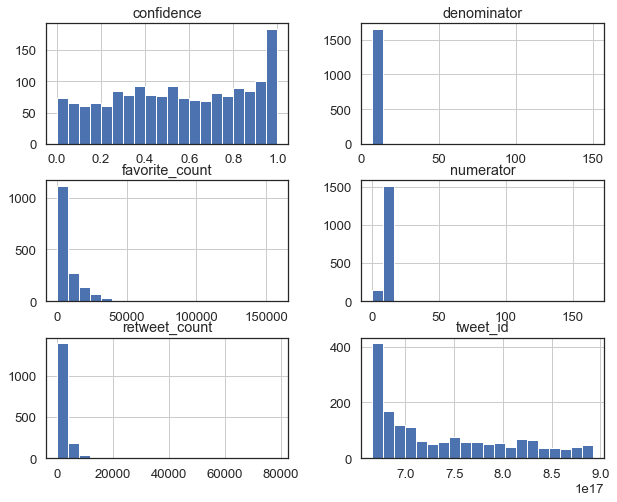

In [70]:
# let us visualize the data
df_main.hist(bins=20,figsize=[10,8]);

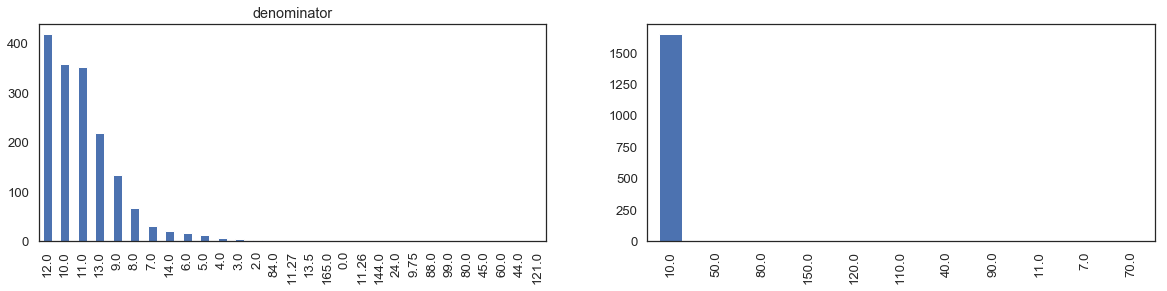

In [71]:
# rating numerator and denominator
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[20,4])
df_main.numerator.value_counts().plot(kind='bar', ax=axes[0]);
df_main.denominator.value_counts().plot(kind='bar', ax=axes[1]);
axes[0].set_title('numerator')
axes[0].set_title('denominator');

In [72]:
df_main.denominator.value_counts()

10.0     1647
50.0     2   
80.0     2   
150.0    1   
120.0    1   
110.0    1   
40.0     1   
90.0     1   
11.0     1   
7.0      1   
70.0     1   
Name: denominator, dtype: int64

it seems that the denominator have very few occurences where it is different than 10. In order to better understand the data, we can combine the numerator and the denominator into 1 `rating` column.

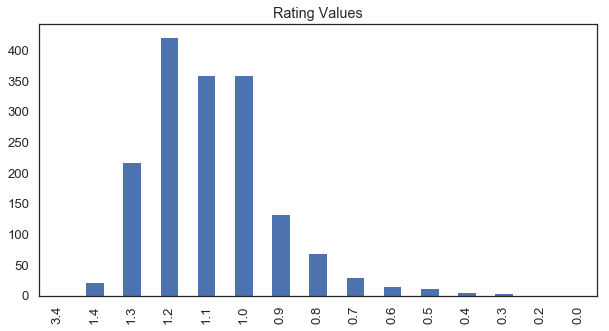

In [73]:
df_main['rating'] = round(df_main['numerator'] / df_main['denominator'], 1) # rounding to the nearest tenth to have a smooth curve
df_main.rating.value_counts().sort_index(ascending=False).plot(kind='bar',figsize=[10,5]);
plt.title('Rating Values');

As expected, most of the values are above 1. The most common value is 1.2 (12/10).

In [74]:
# show some description of the new variable
df_main.rating.describe()

count    1659.000000
mean     1.083183   
std      0.186195   
min      0.000000   
25%      1.000000   
50%      1.100000   
75%      1.200000   
max      3.400000   
Name: rating, dtype: float64

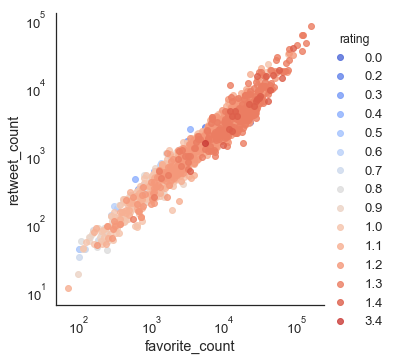

In [75]:
# Question do people agree with these ratings?
sns.lmplot(x='favorite_count',y='retweet_count',data=df_main,hue='rating',fit_reg=False, palette='coolwarm');
plt.xscale('log');
plt.yscale('log');

From the above plot, it seems clear that a higher rating (hotter color) is associated with higher favorit and retweet counts. So, the answer to the above question seems to be: yes, people agree with the rating in general

#### Progress over time

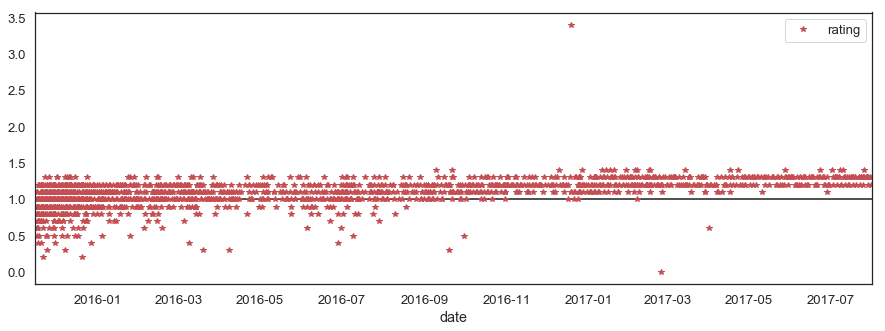

In [76]:
# rating over time
df_main.plot(x='date',y='rating',style='r*', figsize=[15,5]);
plt.hlines(y=1, xmin=min(df_main['date']),xmax=max(df_main['date'])) # hz line at 1 to show low ratings

The account was very consistent in rating dogs. Low rating tweets decreased greatly with time, and on average the rating increased with time.

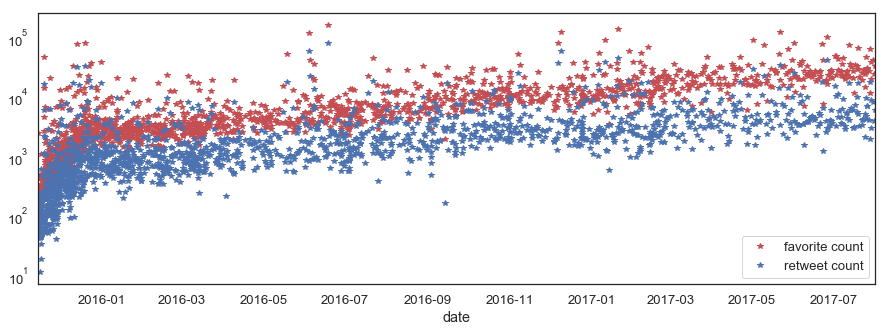

In [77]:
# favorite count and retweet count with time
axes = df_main.plot(x='date',y='favorite_count',style='r*', figsize=[15,5],label='favorite count');
df_main.plot(x='date',y='retweet_count',style='b*', figsize=[15,5],label='retweet count', ax=axes);
plt.legend();
plt.yscale('log')

This shows a gradual increase in the retweet and favorite count as a function of time.

#### Dog types and breeds

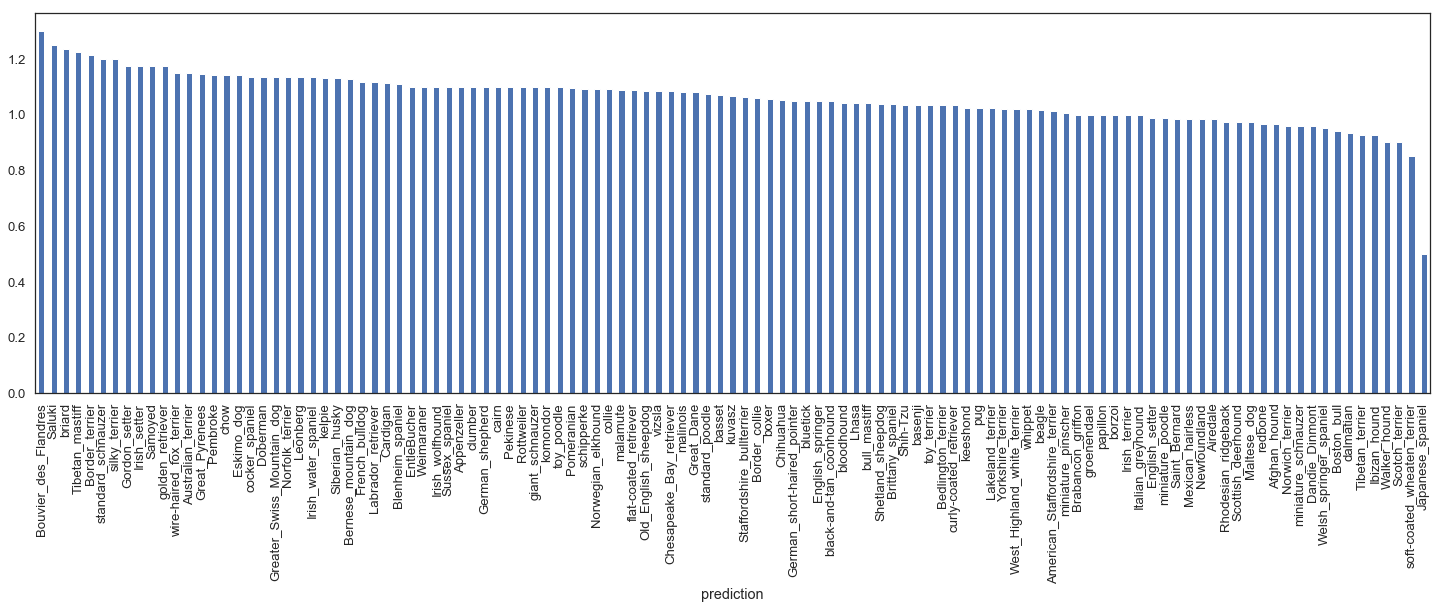

In [78]:
# what are the most popular dogs
df_main.groupby('prediction')['rating'].mean().sort_values(ascending=False).plot(kind='bar',figsize=[25,7]);

According to the above graph, the highest rated dog is the 'Bouvier des Flandres' and the least rated one is the 'Japanese spaniel'
Here is a photo of both dogs side by side:

<table>
    <tr>
        <td>
            <center>
                <h4>
            Highest rated dog breed
                </h4>
            </center>
        </td>
        <td>
            <center>
                <h4>
            Lowest rated dog breed
                </h4>
            </center>
        </td>
    </tr>
    <tr>
        <td>
<img src="https://pbs.twimg.com/ext_tw_video_thumb/861288473281437696/pu/img/RERGmRgPyaaaB-tB.jpg"  height=100/>
        </td>
        <td>
<img src="https://pbs.twimg.com/media/CWZBsjPWsAAZFFl.jpg"  height=100/>
        </td>
    </tr>
</table>

**Note:** Since we are taking the mean value and some dogs are included only few times (or even just once), this analysis may not be very accurate but it is still a nice comparison.

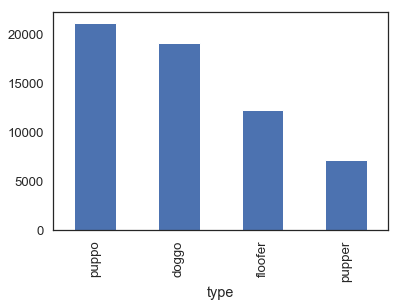

In [79]:
# rating of dog types

df_main.groupby('type')['favorite_count'].mean().sort_values(ascending=False).plot(kind='bar');

'puppo' seems to be the most loved type of dogs and 'pupper' the least.

Finally, we can try to test a linear reggression model. favorite_count seems to be linked to retweet_count.

In [80]:
df_main['intercept'] = 1
x = df_main[['intercept','retweet_count']]
y = df_main['favorite_count']

In [81]:
model = sm.OLS(y,x).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                 1.081e+04
Date:                Sat, 14 Mar 2020   Prob (F-statistic):               0.00
Time:                        20:54:43   Log-Likelihood:                -16370.
No. Observations:                1659   AIC:                         3.274e+04
Df Residuals:                    1657   BIC:                         3.275e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      2156.3242    130.875     16.476      0.000    1899.626    2413.022
retweet_count     2.5820      0.025    103.981      0.000       2.533       2.631
==============================================================================
Omnibus:                      427.672   Durbin-Watson:                   0.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15067.027
Skew:                           0.490   Prob(JB):                         0.00
Kurtosis:                      17.731   Cond. No.                     6.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This gives a formula with $R^2 = 0.876$ which indicates a strong correlation.
The formula we have is:

$$ favorite count = 2.58 \times retweet count + 2156.3242 $$

#### Conclusion

In this report we were able to get insights into a twitter account after gathering the data, assessing them and cleaning them.

In [82]:
# save the file
df_main.to_csv('twitter_archive_master.csv',index=False)